In [29]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os

from scipy.ndimage import gaussian_filter

#PW
import torchvision.transforms as T
from PIL import Image
from matplotlib import cm

In [30]:
# train clean images
train_csv = pd.read_csv('mnist_train.csv')
train = train_csv.iloc[:,1:]
train = train.values / 255.
train = np.reshape(train, (-1, 1, 28, 28))
np.save('../data/np/train/raw.npy', train)

In [31]:
# train labels
labels_train = np.zeros_like(train)
labels_train[train >= 0.5] = 1
labels_train[train < 0.5] = 0
np.save('../data/np/train/labels.npy', labels_train)

In [32]:
# train gaussian images
noise = np.random.normal(0, 0.2, train.shape)
mask_overflow_upper = train + noise >= 1.0
mask_overflow_lower = train + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_gaussian2 = train + noise
np.save('../data/np/train/gaussian2.npy', images_gaussian2)

In [33]:
# test clean images
test_csv = pd.read_csv('mnist_test.csv')
test = test_csv.iloc[:,1:]
test = test.values / 255.
test = np.reshape(test, (-1, 1, 28, 28))
np.save('../data/np/test/raw.npy', test)

In [34]:
# test labels
labels = np.zeros_like(test)
labels[test >= 0.5] = 1
labels[test < 0.5] = 0
np.save('../data/np/test/labels.npy', labels)

In [35]:
# test gaussian images
noise = np.random.normal(0, 1, test.shape)
mask_overflow_upper = test + noise >= 1.0
mask_overflow_lower = test + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_gaussian10 = test + noise
np.save('../data/np/test/gaussian10.npy', images_gaussian10)

In [36]:
blurred = gaussian_filter(train, sigma=(0,0,0.5,0.5))

In [37]:
test.shape

(10000, 1, 28, 28)

In [38]:
train.shape

(60000, 1, 28, 28)

In [39]:
blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
#train_torch = torch.from_numpy(train.values)
train_pil = Image.fromarray(np.uint8(cm.gist_earth(np.array(train)*255)))
train_blur = [blurrer(train_pil) for _ in range(4)]

TypeError: Cannot handle this data type

In [41]:
def display(rows, columns, images, values=[], predictions=[]):
    fig = plt.figure(figsize=(9, 11))
    ax = []
    for i in range(columns*rows):
        img = images[i,0,:,:]
        ax.append(fig.add_subplot(rows, columns, i+1))
        title = ""
        if(len(values) == 0):
            title = "Pred:" + str(predictions[i])
        elif(len(predictions) == 0):
            title = "Value:" + str(values[i])
        elif(len(values) != 0 and len(predictions) != 0):
            title = "Value:" + str(values[i]) + "\nPred:" + str(predictions[i])
        ax[-1].set_title(title)  # set title
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.show()

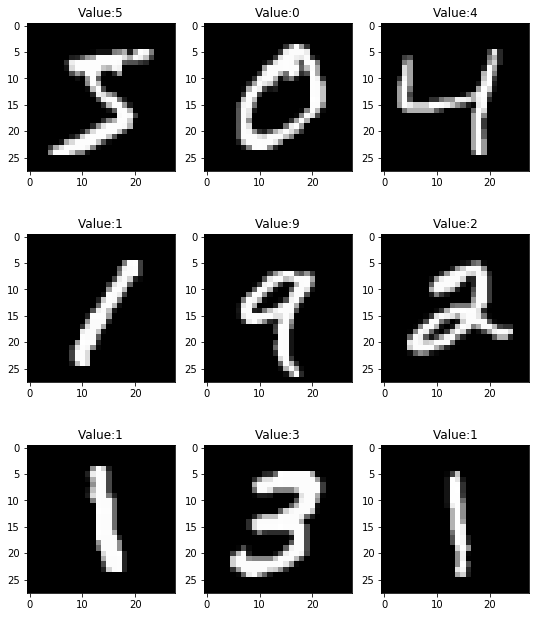

In [42]:
display(rows=3, columns=3, images=train, values=train_csv.iloc[:,0], predictions=[])

In [43]:
def remove(digit, x, y):
    idx = (y != digit).nonzero()
    return x[idx], y[idx], idx

In [44]:
#train_no3, labels_train_no3 = remove(3, train, labels_train)
n_cut = 4
train_cut, labels_train_cut, idx_cut = remove(n_cut, train, train_csv.iloc[:,0].values)

In [45]:
train_cut = np.reshape(train_cut, (-1, 1, 28, 28))
train_cut.shape

(54158, 1, 28, 28)

In [46]:
labels_train_cut.shape

(54158,)

In [75]:
np.save('../data/np/train/images_cut.npy', train_cut)
np.save('../data/np/train/labels_cut.npy', labels_train_cut)
#np.save('../data/np/test/images_cut.npy', test_cut)
#np.save('../data/np/test/labels_cut.npy', labels_test_cut)

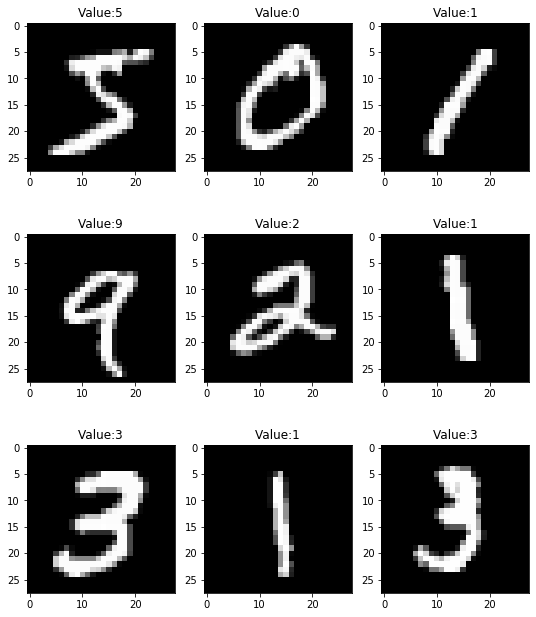

In [47]:
display(rows=3, columns=3, images=train_cut, values=labels_train_cut, predictions=[])

In [48]:
train_frankenstein = np.empty((len(train),1,28,28))
for i in range(len(train)):
    idxs = []    
    for j in range(4):
        r = np.random.randint(0,high=len(train))
        idxs.append(r)
    frankenstein = np.zeros((28,28))
    frankenstein[0:14,0:14] = train[idxs[0]][0,0:14,0:14]
    frankenstein[14:,0:14] = train[idxs[1]][0,14:,0:14]
    frankenstein[0:14,14:] = train[idxs[2]][0,0:14,14:]
    frankenstein[14:,14:] = train[idxs[3]][0,14:,14:]
    train_frankenstein[i] = frankenstein
train_frankenstein.shape

(60000, 1, 28, 28)

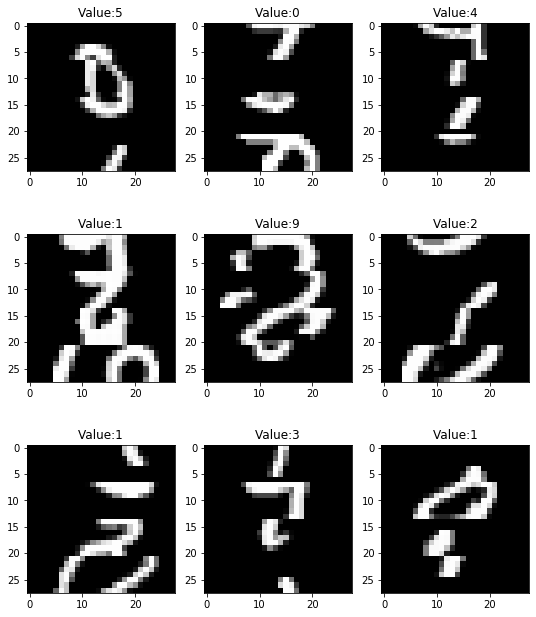

In [65]:
display(rows=3, columns=3, images=train_frankenstein, values=train_csv.iloc[:,0], predictions=[])

In [92]:
train_quarters = train.flatten()
labels_train_quarters = labels_train.flatten()
#split into quarters
#train_quarters = train_quarters.reshape(train.shape[0]*4,1,14,14)
#labels_train_quarters = labels_train_quarters.reshape(train.shape[0]*4,1,14,14)
#split into halves
train_quarters = train_quarters.reshape(train.shape[0]*2,1,14,28)
labels_train_quarters = labels_train_quarters.reshape(train.shape[0]*2,1,14,28)
p = np.random.permutation(train_quarters.shape[0])
train_frankenstein = train_quarters[p]
labels_train_frankenstein = labels_train_quarters[p]
train_frankenstein = train_frankenstein.reshape(train.shape[0],1,28,28)
labels_train_frankenstein = labels_train_frankenstein.reshape(train.shape[0],1,28,28)
values_frankenstein = train_csv.iloc[:,0][p]
np.save('../data/np/train/images_frankenstein.npy', train_frankenstein)
np.save('../data/np/train/labels_frankenstein.npy', labels_train_frankenstein)

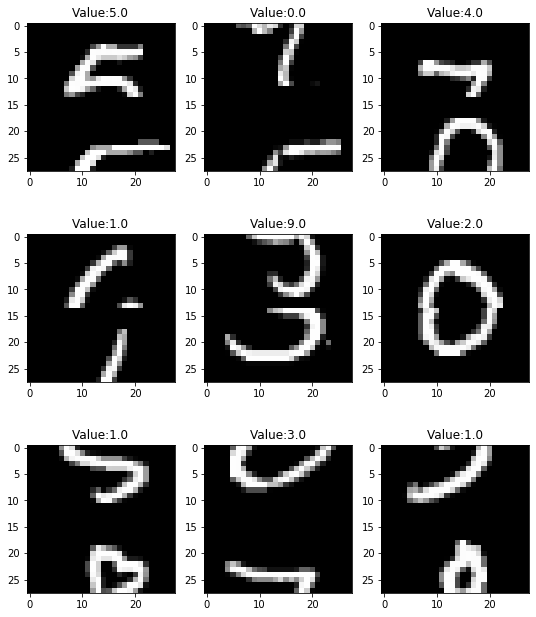

In [89]:
display(rows=3, columns=3, images=train_frankenstein, values=values_frankenstein, predictions=[])

In [119]:
np.array(train_blur[0]).shape
train_blur[0] = np.array(train_blur).reshape(-1, 1, 28, 28)
train_blur[0].shape
#display(rows=r, columns=c, images=np.array(train_blur[0]), values=train_csv.iloc[:,0], predictions=[])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [40]:
display(train_blur)

[<PIL.Image.Image image mode=RGBA size=785x60000 at 0x7FBE60531B70>,
 <PIL.Image.Image image mode=RGBA size=785x60000 at 0x7FBE608DAA20>,
 <PIL.Image.Image image mode=RGBA size=785x60000 at 0x7FBE609C6160>,
 <PIL.Image.Image image mode=RGBA size=785x60000 at 0x7FBE609C6780>]

In [36]:
def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    #plt.tight_layout()

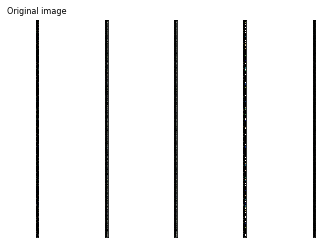

In [37]:
plot(train_blur, train_pil)